### Lastname: PRIEUR

### Name: Dimitri


# Supervised Learning Project

# Importation

In [2]:
import os
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D,Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading dataset

In [4]:
(df_train, df_validation, df_test),df_info = tfds.load(
    "ColorectalHistology",
    shuffle_files = True,
    as_supervised = True,
    with_info=True,
    split = ['train[:70%]', 'train[70%:85%]','train[85%:]']
    )


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incomplete0Q1WN1/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [5]:
df_info

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='~/tensorflow_datasets/colorectal_histology/2.0.0',
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis,

In [6]:
len(df_train)

3500

In [7]:
len(df_test)

750

In [8]:
df_train

<PrefetchDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# x_train, y_train = next(iter(df_train))
# x_validation, y_validation = next(iter(df_validation))
# x_test, y_test = next(iter(df_test))

In [10]:
# df_train.take(1)

In [11]:
df_final_train = tfds.as_dataframe(df_train.take(len(df_train)), df_info)
df_final_validation = tfds.as_dataframe(df_train.take(len(df_validation)), df_info)
df_final_test = tfds.as_dataframe(df_test.take(len(df_test)), df_info)


In [12]:
df_final_train[0:10]

,image,label
0,"[[[238, 211, 226], [232, 205, 220], [233, 210,...",6
1,"[[[241, 241, 243], [242, 242, 244], [243, 243,...",7
2,"[[[146, 70, 116], [148, 72, 118], [183, 92, 12...",2
3,"[[[237, 237, 237], [238, 238, 238], [238, 238,...",6
4,"[[[240, 229, 235], [243, 232, 238], [245, 236,...",2
5,"[[[83, 39, 92], [89, 45, 98], [102, 49, 103], ...",3
6,"[[[167, 57, 76], [167, 57, 76], [160, 36, 72],...",4
7,"[[[126, 44, 84], [123, 40, 82], [131, 48, 90],...",0
8,"[[[242, 243, 245], [242, 243, 245], [242, 243,...",7
9,"[[[242, 244, 243], [242, 244, 243], [241, 243,...",7


In [13]:
print("Samples training:", df_final_train.shape)
print("Samples validation:", df_final_validation.shape)
print("Samples test:", df_final_test.shape)

Samples training: (3500, 2)
Samples validation: (750, 2)
Samples test: (750, 2)


# Visualization of the various images

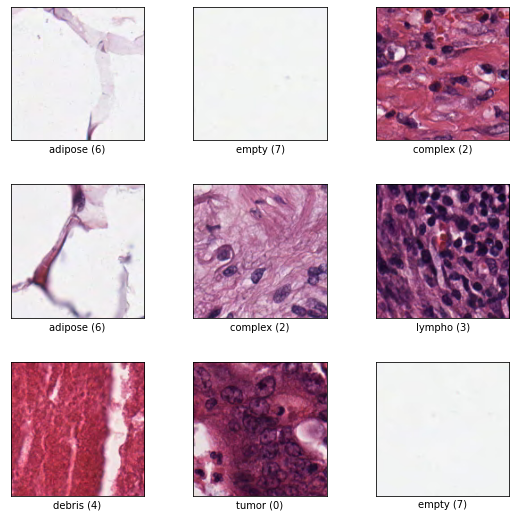

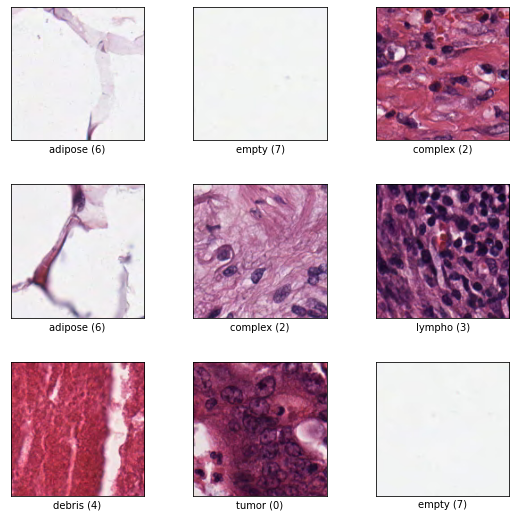

In [14]:
tfds.show_examples(df_train, df_info)

In [15]:
image_list = {0 : 'TUMOR', 1 : 'STROMA', 2 : 'COMPLEX', 3 : 'LYMPHO', 4 : 'DEBRIS',  5 : 'MUCOSA', 6 : "ADIPOSE", 7 : "EMPTY"}

In [16]:
def display_images(images, labels, max_images, columns=5, width=25, height=25):

    images_showing = images[0:max_images]
    plt.figure(figsize=(width, height))

    for i, image in enumerate(images_showing):
        plt.subplot(len(images_showing) / columns + 1, columns, i + 1)
        test = image_list.get(labels[i],"nothing")
        plt.imshow(image)
        plt.title('{} image'.format(test), size=15)

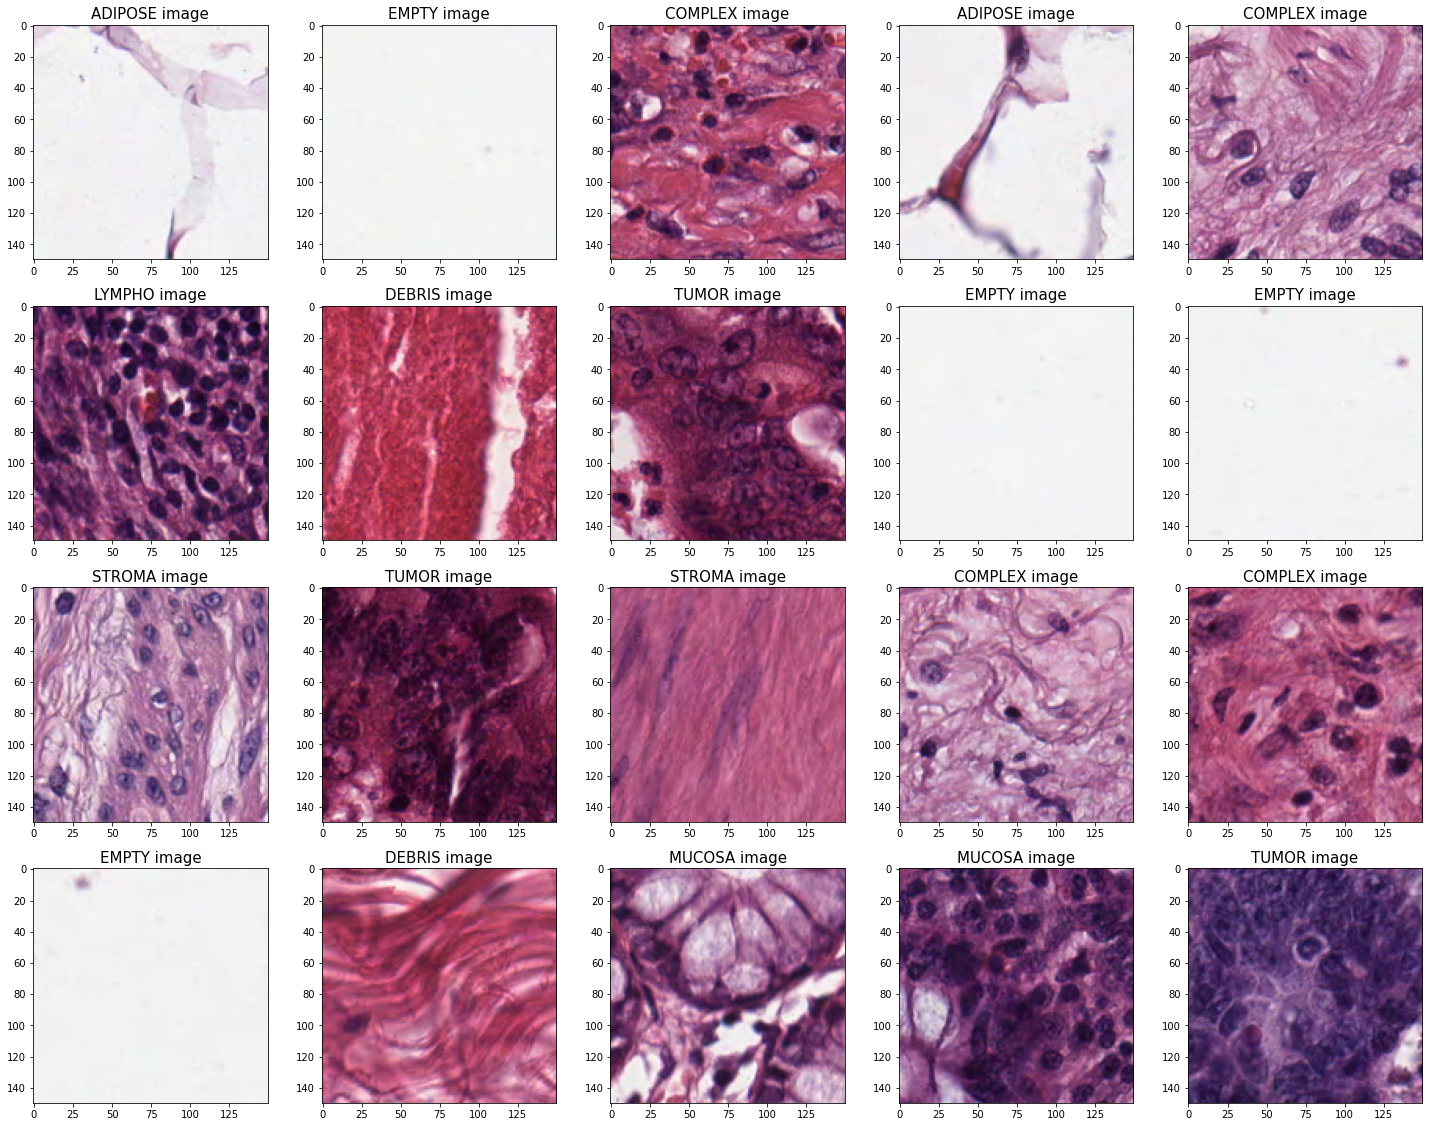

In [17]:
display_images(list(df_final_train["image"]), list(df_final_train["label"]),20)

# Data Preprocessing

In [18]:
size_batch = 16
epoch = 20

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = df_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
df_val = df_validation.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
df_train = df_train.batch(size_batch)
df_val = df_validation.batch(size_batch)
df_test = df_test.batch(size_batch)

In [21]:
from tensorflow.keras.layers import Rescaling


normalization_layer = Rescaling(1./255)

In [22]:
normalized_ds = df_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.003921569 1.0


In [23]:
image_batch

<tf.Tensor: shape=(16, 150, 150, 3), dtype=float32, numpy=
array([[[[0.18823531, 0.03921569, 0.13725491],
         [0.21176472, 0.04705883, 0.14117648],
         [0.227451  , 0.0627451 , 0.15686275],
         ...,
         [0.3921569 , 0.09019608, 0.16078432],
         [0.38823533, 0.08627451, 0.15686275],
         [0.37647063, 0.07843138, 0.15686275]],

        [[0.20000002, 0.02352941, 0.15294118],
         [0.22352943, 0.03921569, 0.15294118],
         [0.22352943, 0.03921569, 0.15294118],
         ...,
         [0.38431376, 0.09803922, 0.16470589],
         [0.3803922 , 0.09411766, 0.16078432],
         [0.3647059 , 0.08627451, 0.15686275]],

        [[0.21176472, 0.03921569, 0.1764706 ],
         [0.21568629, 0.03921569, 0.16078432],
         [0.21176472, 0.03529412, 0.15686275],
         ...,
         [0.30980393, 0.08627451, 0.15294118],
         [0.30588236, 0.08235294, 0.14901961],
         [0.3137255 , 0.07450981, 0.13725491]],

        ...,

        [[0.4784314 , 0.09019608,

# First Model : Base

In [75]:
SEED = 456

In [76]:
# set seed for reproducibility
tf.keras.utils.set_random_seed(SEED)

model = Sequential([
    
    Rescaling(1./255, input_shape=(image_batch[0].shape)),

    Conv2D(8, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Conv2D(16, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation="relu"),
    Dense(8, activation='softmax'),
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 150, 150, 8)       224       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 37, 37, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 37, 37, 32)      

In [77]:
model.compile(optimizer="Adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
# Logits = false because we have put a softmax function at the end layer of our sequence.


In [78]:
model_fitting = model.fit(
    df_train,
    validation_data=df_val,
    batch_size=size_batch,
    epochs=epoch, 
    steps_per_epoch=None,
)

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 1.1700 - accuracy: 0.4871 - val_loss: 0.9603 - val_accuracy: 0.5680
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.8161 - accuracy: 0.6717 - val_loss: 0.6455 - val_accuracy: 0.7560
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.7063 - accuracy: 0.7231 - val_loss: 0.6308 - val_accuracy: 0.7680
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.6208 - accuracy: 0.7703 - val_loss: 0.5664 - val_accuracy: 0.7880
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5468 - accuracy: 0.7931 - val_loss: 0.5564 - val_accuracy: 0.8000
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.4820 - accuracy: 0.8151 - val_loss: 0.5710 - val_accuracy: 0.7760
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.4263 - accuracy: 0.8406 - val_loss: 0.5464 - val_accuracy: 0.8000
Epoch

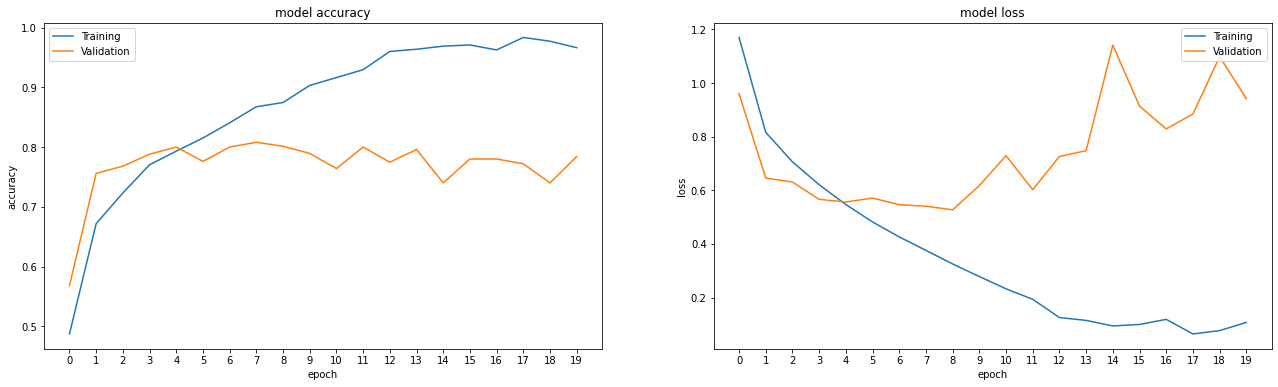

In [79]:
plt.figure(figsize=(22,6))

plt.subplot(1,2,1)
plt.plot(model_fitting.history['accuracy'])
plt.plot(model_fitting.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_fitting.history['loss'])
plt.plot(model_fitting.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

We can see that the model is slightly overfiting 

# Second Model : Dropout

In [52]:
# set seed for reproducibility
tf.keras.utils.set_random_seed(SEED)

model_dropout = Sequential([
    
    Rescaling(1./255, input_shape=(image_batch[0].shape)),

    Conv2D(8, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Conv2D(16, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Dropout(0.3),


    Flatten(),
    Dense(128, activation="relu"),
    Dense(8, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        4

In [53]:
model_dropout.compile(optimizer="Adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
# Logits = false because we have put a softmax function at the end layer of our sequence.

In [54]:
model_fitting_dropout = model_dropout.fit(
    df_train,
    validation_data=df_val,
    batch_size=size_batch,
    epochs=epoch, 
    steps_per_epoch=None,
)

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 1.3446 - accuracy: 0.4200 - val_loss: 0.9523 - val_accuracy: 0.5933
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.8185 - accuracy: 0.6586 - val_loss: 0.7958 - val_accuracy: 0.6707
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.7096 - accuracy: 0.7203 - val_loss: 0.6541 - val_accuracy: 0.7920
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.6205 - accuracy: 0.7563 - val_loss: 0.7168 - val_accuracy: 0.7120
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5771 - accuracy: 0.7703 - val_loss: 0.6382 - val_accuracy: 0.7547
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5126 - accuracy: 0.8091 - val_loss: 0.5485 - val_accuracy: 0.8013
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.4916 - accuracy: 0.8151 - val_loss: 0.5563 - val_accuracy: 0.8120
Epoch

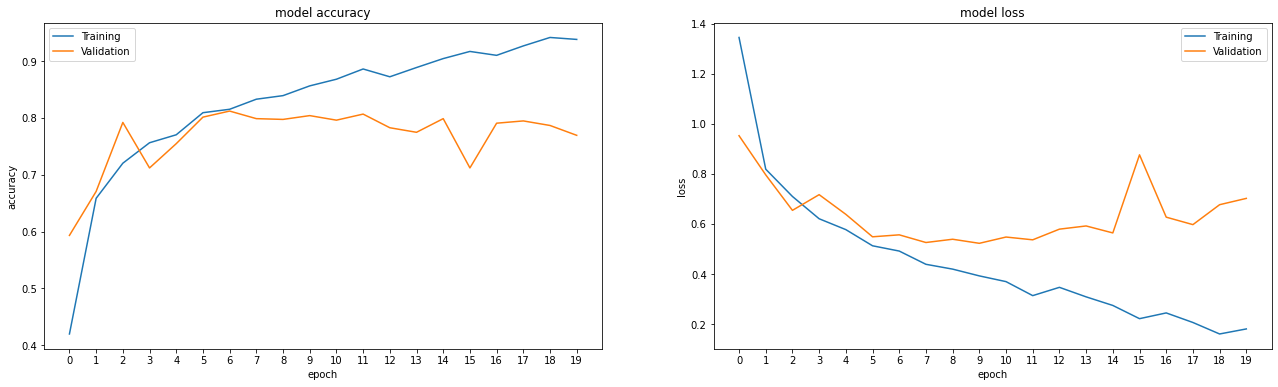

In [55]:
plt.figure(figsize=(22,6))

plt.subplot(1,2,1)
plt.plot(model_fitting_dropout.history['accuracy'])
plt.plot(model_fitting_dropout.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_fitting_dropout.history['loss'])
plt.plot(model_fitting_dropout.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

# Third model: Dropout

In [33]:
# set seed for reproducibility
tf.keras.utils.set_random_seed(SEED)

model_dropout2 = Sequential([
    
    Rescaling(1./255, input_shape=(image_batch[0].shape)),

    Conv2D(8, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    

    Conv2D(16, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    Dropout(0.3),

    Dense(8, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        4

In [34]:
model_dropout2.compile(optimizer="Adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
# Logits = false because we have put a softmax function at the end layer of our sequence.

In [35]:
model_fitting_dropout2 = model_dropout2.fit(
    df_train,
    validation_data=df_val,
    batch_size= size_batch,
    epochs=epoch, 
    steps_per_epoch=None,
)

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 1.2563 - accuracy: 0.4583 - val_loss: 0.8815 - val_accuracy: 0.6493
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.9431 - accuracy: 0.6077 - val_loss: 0.6787 - val_accuracy: 0.7440
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.7726 - accuracy: 0.6820 - val_loss: 0.7094 - val_accuracy: 0.7253
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.7338 - accuracy: 0.7217 - val_loss: 0.6559 - val_accuracy: 0.7360
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5975 - accuracy: 0.7800 - val_loss: 0.6115 - val_accuracy: 0.7720
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5827 - accuracy: 0.7780 - val_loss: 0.7235 - val_accuracy: 0.7107
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.5706 - accuracy: 0.7823 - val_loss: 0.5935 - val_accuracy: 0.7933
Epoch

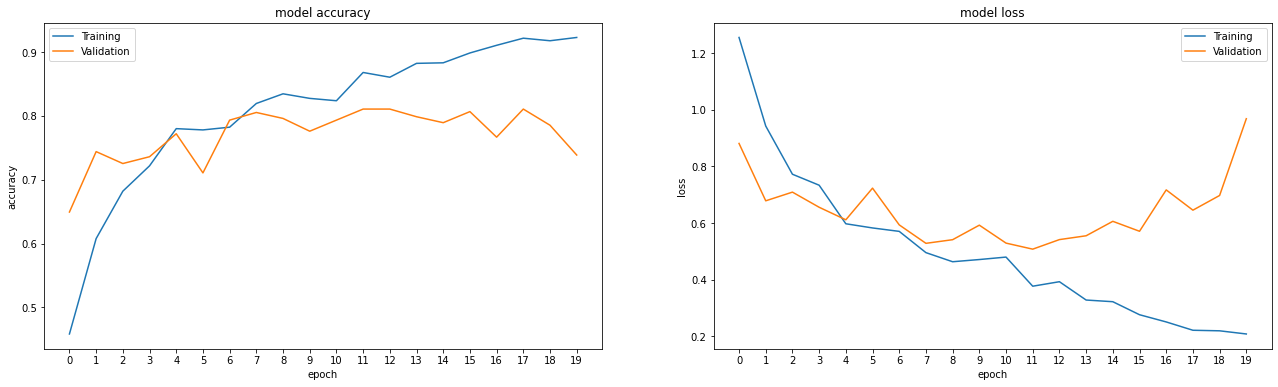

In [36]:

plt.figure(figsize=(22,6))

plt.subplot(1,2,1)
plt.plot(model_fitting_dropout2.history['accuracy'])
plt.plot(model_fitting_dropout2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_fitting_dropout2.history['loss'])
plt.plot(model_fitting_dropout2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

# Fourth Model : Data Augmentation

In [112]:
from tensorflow.keras import layers


In [113]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(mode="horizontal_and_vertical", seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.RandomZoom(0.2, seed=SEED),
  ]
)

In [114]:
model_augment = Sequential([
    data_augmentation,
    model_dropout
])

In [115]:
model_augment.compile(optimizer="Adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])


In [116]:
model_fitting_augment = model_augment.fit(
    df_train,
    validation_data=df_val,
    batch_size=size_batch,
    epochs=epoch, 
    steps_per_epoch=None,
)

Epoch 1/20
219/219 [==============================] - 6s 23ms/step - loss: 0.2017 - accuracy: 0.9283 - val_loss: 0.4928 - val_accuracy: 0.8360
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1858 - accuracy: 0.9323 - val_loss: 0.2836 - val_accuracy: 0.8960
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1797 - accuracy: 0.9374 - val_loss: 0.3505 - val_accuracy: 0.8747
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1938 - accuracy: 0.9286 - val_loss: 0.3252 - val_accuracy: 0.8933
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1660 - accuracy: 0.9423 - val_loss: 0.2394 - val_accuracy: 0.9107
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1944 - accuracy: 0.9317 - val_loss: 0.2795 - val_accuracy: 0.9173
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1727 - accuracy: 0.9426 - val_loss: 0.3643 - val_accuracy: 0.8747

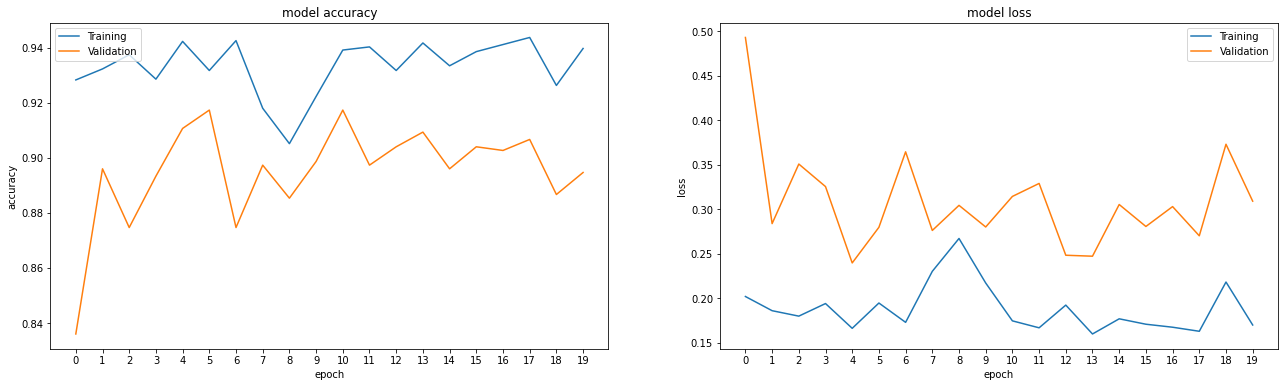

In [117]:

plt.figure(figsize=(22,6))

plt.subplot(1,2,1)
plt.plot(model_fitting_augment.history['accuracy'])
plt.plot(model_fitting_augment.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_fitting_augment.history['loss'])
plt.plot(model_fitting_augment.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

# Fifth Model: Augmented data with Learning Rate Callback

In [103]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [104]:
model_augment_lr = Sequential([
    model_augment
])

In [105]:
model_augment_lr.compile(optimizer="Adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])


In [106]:
model_fitting_augment_lr = model_augment_lr.fit(
    df_train,
    validation_data=df_val,
    batch_size=size_batch,
    epochs=epoch, 
    callbacks=[callback],
    steps_per_epoch=None,
)

Epoch 1/20
219/219 [==============================] - 6s 23ms/step - loss: 0.1963 - accuracy: 0.9354 - val_loss: 0.3898 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.2127 - accuracy: 0.9254 - val_loss: 0.3139 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.1932 - accuracy: 0.9329 - val_loss: 0.3198 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.1890 - accuracy: 0.9283 - val_loss: 0.2682 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.2402 - accuracy: 0.9197 - val_loss: 0.2971 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1950 - accuracy: 0.9289 - val_loss: 0.3124 - val_accuracy: 0.8813 - lr: 9.0484e-04
Epoch 7/20
219/219 [==============================] - 5s 22m

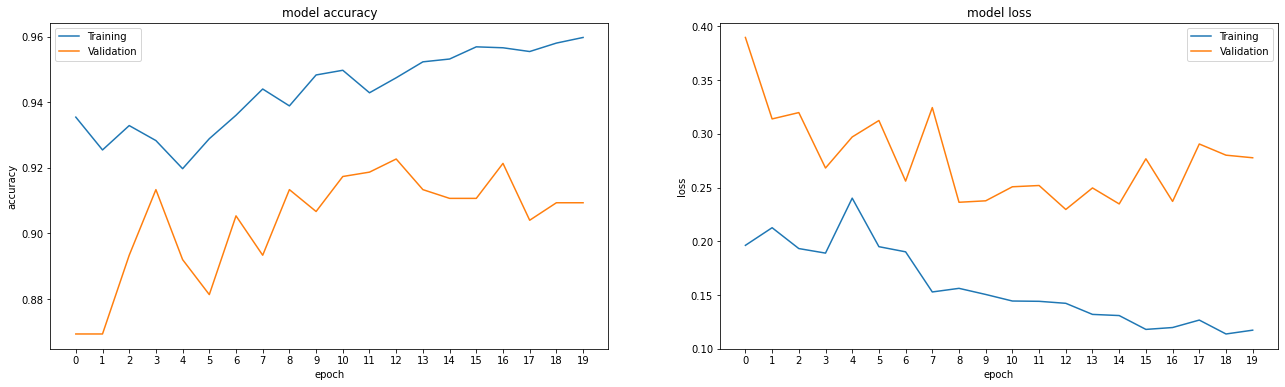

In [107]:
plt.figure(figsize=(22,6))

plt.subplot(1,2,1)
plt.plot(model_fitting_augment_lr.history['accuracy'])
plt.plot(model_fitting_augment_lr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_fitting_augment_lr.history['loss'])
plt.plot(model_fitting_augment_lr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

# Results

In [127]:
score = model_augment_lr.evaluate(df_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2436780333518982
Test accuracy: 0.9253333210945129


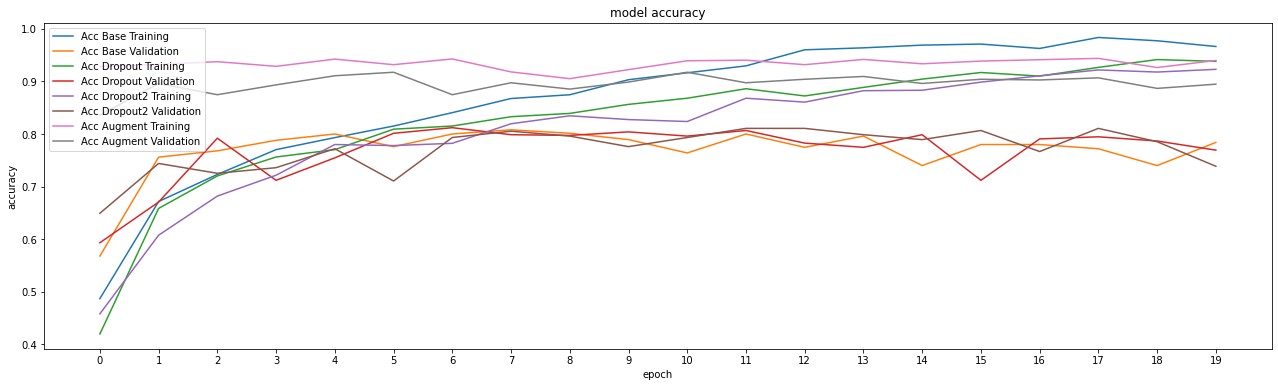

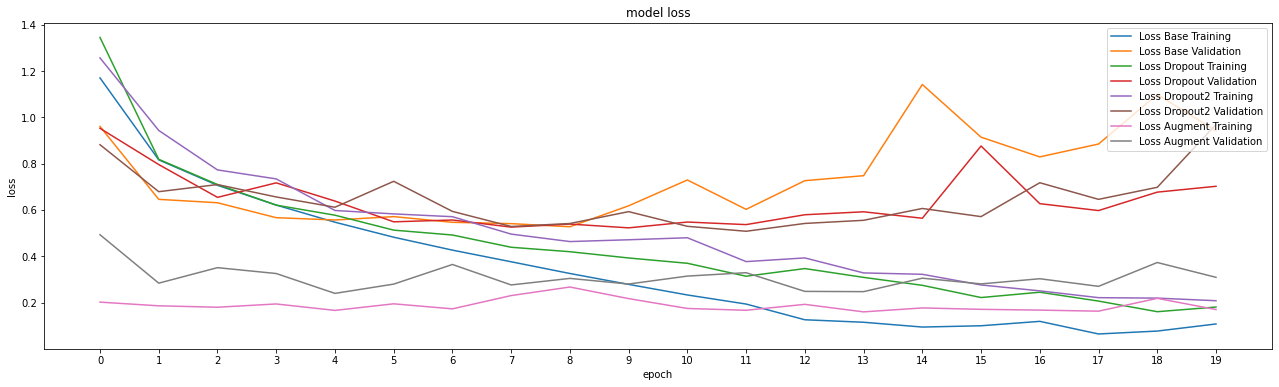

In [118]:
plt.figure(figsize=(22,6))

plt.plot(model_fitting.history['accuracy'])
plt.plot(model_fitting.history['val_accuracy'])
plt.plot(model_fitting_dropout.history['accuracy'])
plt.plot(model_fitting_dropout.history['val_accuracy'])
plt.plot(model_fitting_dropout2.history['accuracy'])
plt.plot(model_fitting_dropout2.history['val_accuracy'])
plt.plot(model_fitting_augment.history['accuracy'])
plt.plot(model_fitting_augment.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Acc Base Training', 'Acc Base Validation', 'Acc Dropout Training', 'Acc Dropout Validation', 'Acc Dropout2 Training', 'Acc Dropout2 Validation', 'Acc Augment Training', 'Acc Augment Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(22,6))
plt.plot(model_fitting.history['loss'])
plt.plot(model_fitting.history['val_loss'])
plt.plot(model_fitting_dropout.history['loss'])
plt.plot(model_fitting_dropout.history['val_loss'])
plt.plot(model_fitting_dropout2.history['loss'])
plt.plot(model_fitting_dropout2.history['val_loss'])
plt.plot(model_fitting_augment.history['loss'])
plt.plot(model_fitting_augment.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Loss Base Training', 'Loss Base Validation', 'Loss Dropout Training', 'Loss Dropout Validation', 'Loss Dropout2 Training', 'Loss Dropout2 Validation', 'Loss Augment Training', 'Loss Augment Validation'], loc='upper right')

plt.show()

In [119]:
# cm = confusion_matrix(test_df.label_num.values, y_preds)

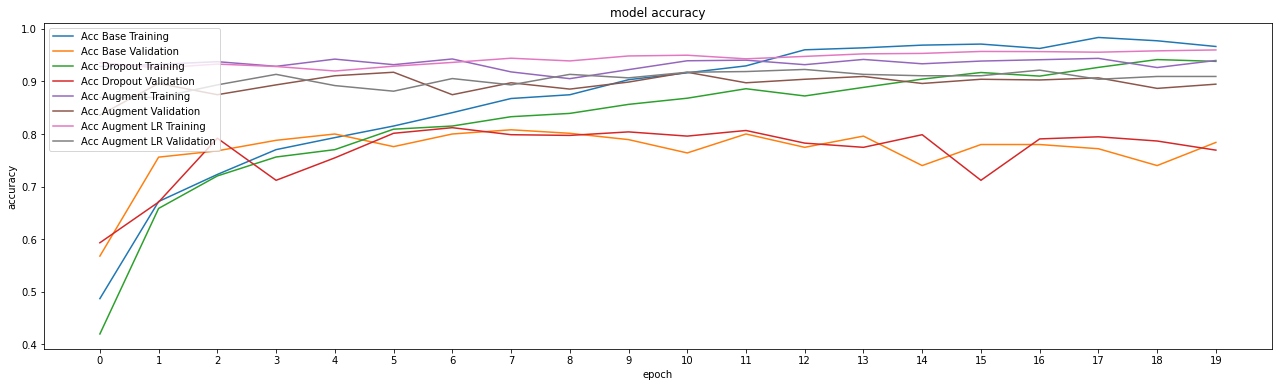

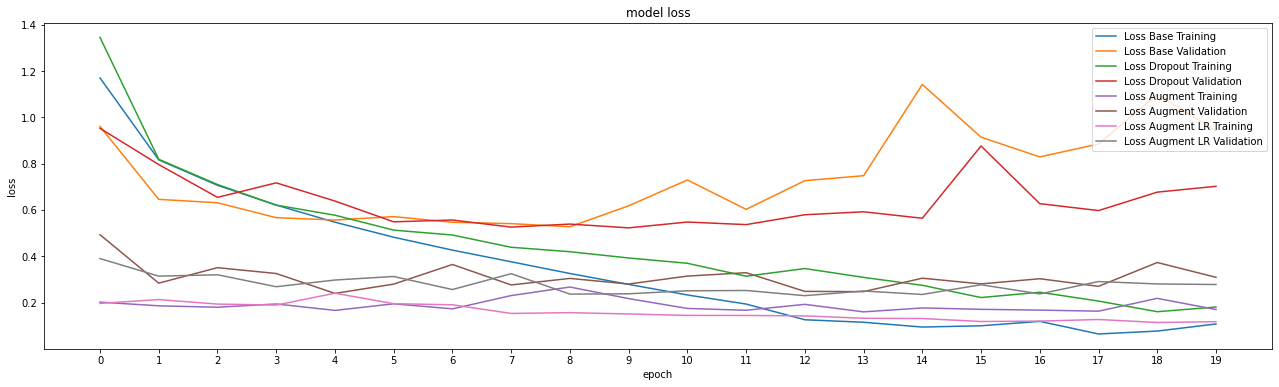

In [120]:
plt.figure(figsize=(22,6))

plt.plot(model_fitting.history['accuracy'])
plt.plot(model_fitting.history['val_accuracy'])
plt.plot(model_fitting_dropout.history['accuracy'])
plt.plot(model_fitting_dropout.history['val_accuracy'])
plt.plot(model_fitting_augment.history['accuracy'])
plt.plot(model_fitting_augment.history['val_accuracy'])
plt.plot(model_fitting_augment_lr.history['accuracy'])
plt.plot(model_fitting_augment_lr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Acc Base Training', 'Acc Base Validation', 'Acc Dropout Training', 'Acc Dropout Validation', 'Acc Augment Training', 'Acc Augment Validation', 'Acc Augment LR Training', 'Acc Augment LR Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(22,6))
plt.plot(model_fitting.history['loss'])
plt.plot(model_fitting.history['val_loss'])
plt.plot(model_fitting_dropout.history['loss'])
plt.plot(model_fitting_dropout.history['val_loss'])
plt.plot(model_fitting_augment.history['loss'])
plt.plot(model_fitting_augment.history['val_loss'])
plt.plot(model_fitting_augment_lr.history['loss'])
plt.plot(model_fitting_augment_lr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Loss Base Training', 'Loss Base Validation', 'Loss Dropout Training', 'Loss Dropout Validation', 'Loss Augment Training', 'Loss Augment Validation', 'Loss Augment LR Training', 'Loss Augment LR Validation'], loc='upper right')

plt.show()

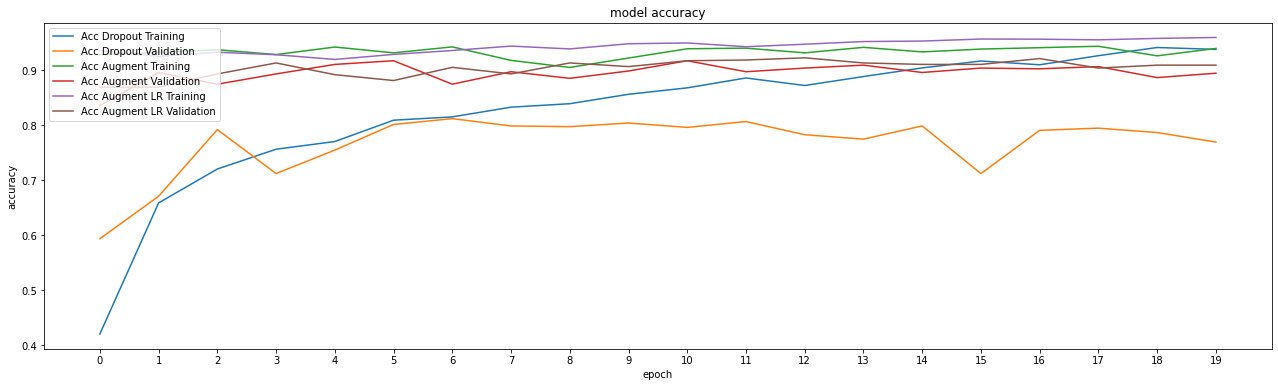

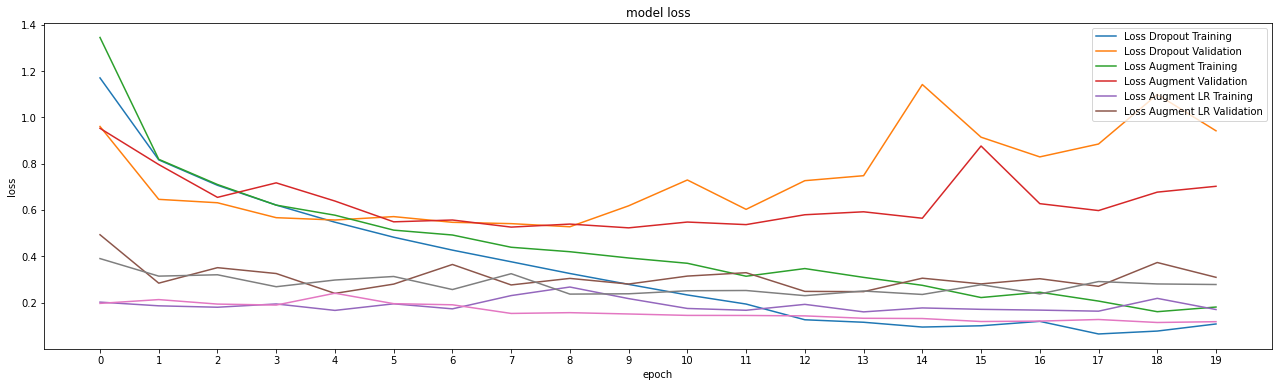

In [121]:
plt.figure(figsize=(22,6))

plt.plot(model_fitting_dropout.history['accuracy'])
plt.plot(model_fitting_dropout.history['val_accuracy'])
plt.plot(model_fitting_augment.history['accuracy'])
plt.plot(model_fitting_augment.history['val_accuracy'])
plt.plot(model_fitting_augment_lr.history['accuracy'])
plt.plot(model_fitting_augment_lr.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Acc Dropout Training', 'Acc Dropout Validation', 'Acc Augment Training', 'Acc Augment Validation', 'Acc Augment LR Training', 'Acc Augment LR Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(22,6))
plt.plot(model_fitting.history['loss'])
plt.plot(model_fitting.history['val_loss'])
plt.plot(model_fitting_dropout.history['loss'])
plt.plot(model_fitting_dropout.history['val_loss'])
plt.plot(model_fitting_augment.history['loss'])
plt.plot(model_fitting_augment.history['val_loss'])
plt.plot(model_fitting_augment_lr.history['loss'])
plt.plot(model_fitting_augment_lr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,20))
plt.legend(['Loss Dropout Training', 'Loss Dropout Validation', 'Loss Augment Training', 'Loss Augment Validation', 'Loss Augment LR Training', 'Loss Augment LR Validation'], loc='upper right')

plt.show()